In [52]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('summer_internship_takehome.csv')

#distribution histogram
def histogram(df, metric):
    fig,ax = plt.subplots(figsize=(10,10))
    n,bins,patches = ax.hist(df, 40, density=1, facecolor='blue', alpha=0.5, edgecolor='black')
    ax.set_title(f'Distribution of {metric} Profit Margin', fontsize=15)
    ax.set_xlabel(f'{metric} Profit Margin (%)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    

In [58]:
#calculating profit margin (net_revenue/gross revenue) * 100
df['profit_margin'] = (df['Gross revenue'] - (df['Fixed cost'] + df['Variable cost'] + df['Rental cost']))/(df['Gross revenue']) * 100

In [59]:
#getting aggregate median and mean profit margins
df_mean = df.groupby('Location number').mean()['profit_margin']
df_median = df.groupby('Location number').median()['profit_margin']

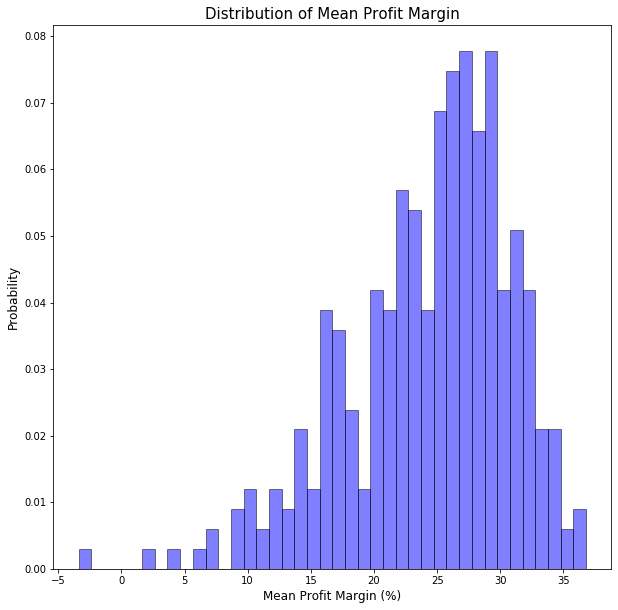

In [60]:
#distribution of median profit margin
histogram(df_mean, 'Mean')

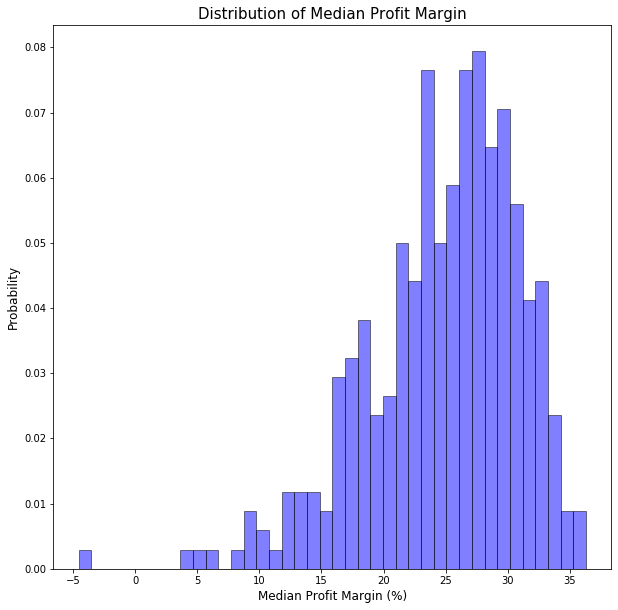

In [61]:
#distribution of median profit margin
histogram(df_median, 'Median')